In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import figure
from itertools import product
import seaborn as sns
import math as m
# import mpmath
import tensorflow as tf
import csv
import pandas as pd


In [112]:
RIS_ROW = 3
RIS_COL = 3
RIS_element = RIS_ROW*RIS_COL
Frequency = 5.8*(10**9)     # Frequency in GHz
c = 3*(10**8)               # speed of light
Lambda = c/Frequency
df = Lambda/2

EbNo = np.power(10, (30/10))  # 30 db Eb_No (transmit power upon noise variance)
# print(EbNo)

""" Angles of elevation and azimuth for each elements"""
theta_i = -27.5             # Eleveation angle of incidence
theta_d = -27.5            # Eleveation angle of reflection (two degrees were best : 84 & 90 )
phi_i = 90                 # Azimuth angle of incidence
angles = []

for i in np.arange(90, 181, 5):      # start, end and gap
  angles.append(i)                   # theta d varies for every 6 degrees in the
phi_d = np.array(angles)
print(phi_d)

[ 90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180]


# 1. Channels

In [114]:
def Channels(theta, phi):
  PHI = df*m.sin(m.radians(phi))*m.cos(m.radians(theta))/Lambda
  PSI = df*m.sin(m.radians(theta))/Lambda

  angle_1 = 2*m.pi*PHI
  angle_2 = 2*m.pi*PSI

  arr_1 = []
  arr_2 = []

  for i in range(RIS_ROW):
    ang = angle_1*i
    arr_1.append(tf.math.exp(complex(0,ang)))
  M_1 = tf.reshape(tf.convert_to_tensor(arr_1),[RIS_ROW,1])

  for i in range(RIS_COL):
    ang = angle_2*i
    arr_2.append(tf.math.exp(complex(0,ang)))
  M_2 = tf.reshape(tf.convert_to_tensor(arr_2), [RIS_COL,1])

  operator = tf.linalg.LinearOperatorKronecker([tf.linalg.LinearOperatorFullMatrix(M_1), tf.linalg.LinearOperatorFullMatrix(M_2)])
  alpha = tf.convert_to_tensor(np.multiply((1/np.sqrt(2)), np.vectorize(complex)(1,1)))

  channel_value = tf.multiply(alpha, operator.to_dense())
  # print(operator.to_dense())
  return channel_value


# 2. All Possible Codewords & Plots

In [115]:
x = [[list(i[x:x+RIS_ROW]) for x in range(0, len(i), RIS_ROW)] for i in product(['0','180'], repeat=RIS_ROW*RIS_COL)]
codewords = np.array(x, dtype='int64')


In [116]:
""" Plotting all the codebooks """
# sns.set()
# colors = ["gray", "lightgray"]
# cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

# for i in codewords:
#   phase = np.array(i)
#   f, ax = plt.subplots(figsize=(3,3))
#   ax = sns.heatmap(phase, cmap = cmap, square = True, linewidth=0.5, cbar_kws ={"shrink": .5})
#   colorbar = ax.collections[0].colorbar
#   colorbar.set_ticks([0, 180])

#   colorbar.set_ticklabels(['0','180'])
#   plt.show()

' Plotting all the codebooks '

# 3. Quantized codewords into complex value's

In [117]:
def codewords_complex():
  Configurations = tf.dtypes.cast(tf.convert_to_tensor(codewords.reshape(2**(RIS_ROW*RIS_COL),RIS_element)), tf.float64)
  rad_to_deg = m.pi/180
  code_radian = tf.math.scalar_mul(rad_to_deg, Configurations)
  phases = tf.complex(tf.math.cos(code_radian), tf.math.sin(code_radian), tf.complex128)
  return phases

In [118]:
# code_matrix = {}
# code_matrix["Angles(In degree)"] = phi_d
# phases = codewords_complex()
# h_tr = Channels(theta_i, phi_i)
# Tx_d1 = 10    # in Meter's

# for index, config in enumerate(phases):
#   SNR = []
#   for angle in phi_d:
#     h_ri = Channels(theta_d,angle)
#     H = tf.transpose(tf.convert_to_tensor(np.multiply(h_tr, h_ri)))
#     configuration = tf.reshape(config, shape=(config.shape[0],1))
#     snr = abs(tf.matmul(H,configuration))**2
#     # print(snr)
#     SNR.append(snr.numpy()[0][0])

#   code_matrix[index] = SNR
#   # figure(figsize=(8,5), dpi=80)
#   # plt.plot(phi_d,SNR, marker='o', linestyle='--', color='r', label='SNR')
#   # plt.xlabel("Angles")
#   # plt.ylabel("SNR Value")
#   # plt.title(f"SNR at each angle with {index} Configuration")
#   # plt.xticks(phi_d, phi_d)
#   # plt.legend()
#   # plt.show()

# import numpy as np
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# a = code_matrix #SNR_maximization # Store your dictionary here

# x, y = zip(*a.keys())
# z = list(a.values())

# # Plotting
# fig = plt.figure(figsize=(20,20))
# ax = fig.gca(projection = '3d')

# # dx = .25 * np.ones(len(x))
# # dy = .25 * np.ones(len(y))
# # dx = np.ones(len(x))
# # dy = np.ones(len(y))
# # dz = z

# ax.set_xlabel('Configurations')
# ax.set_ylabel('Angles')
# ax.set_zlabel('SNR')

# plt.yticks(phi_d, phi_d)
# # plt.xticks(x,x)

# ax.bar3d(x, y, z, dx, dy, dz, color = 'green')
# # ax.plot_surface(x, y, z, cmap ='viridis', edgecolor ='green')
# plt.show()

# 4. Calculate SNR

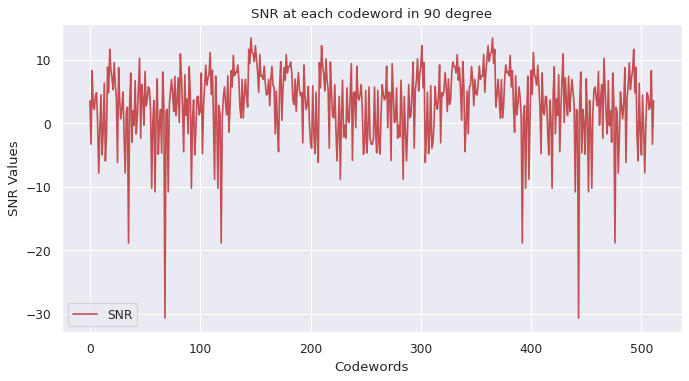

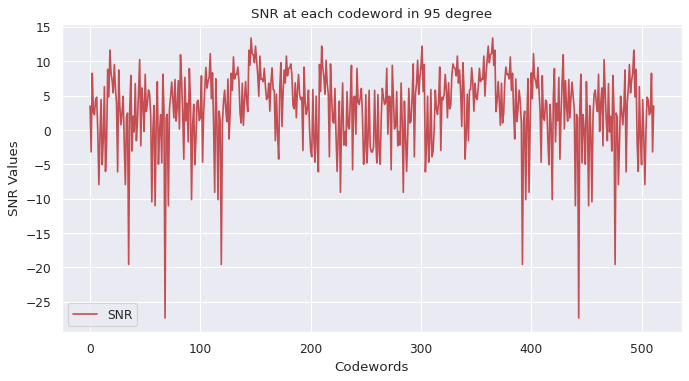

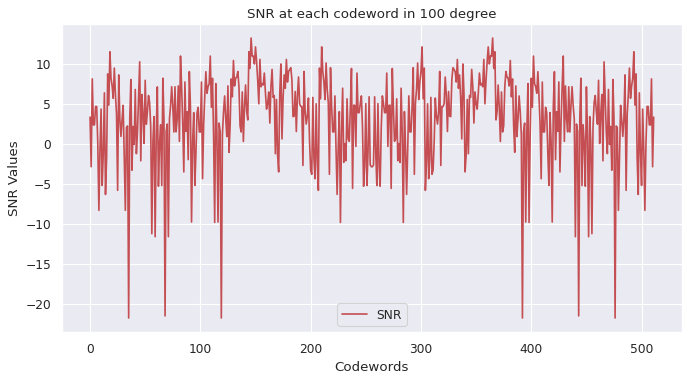

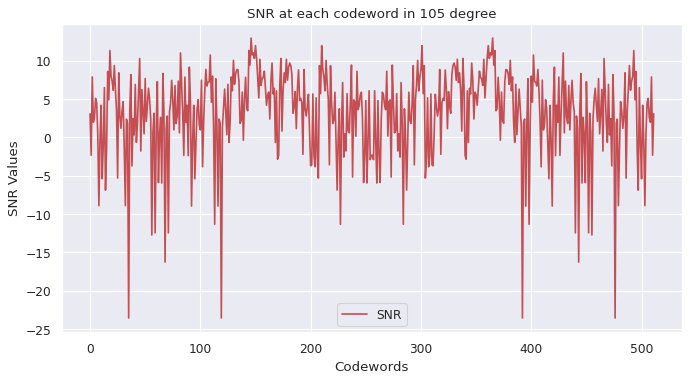

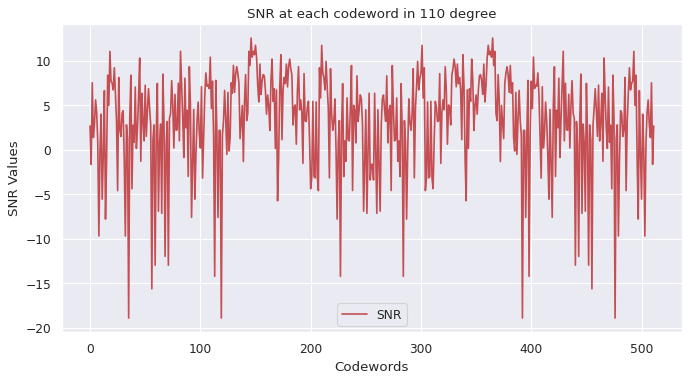

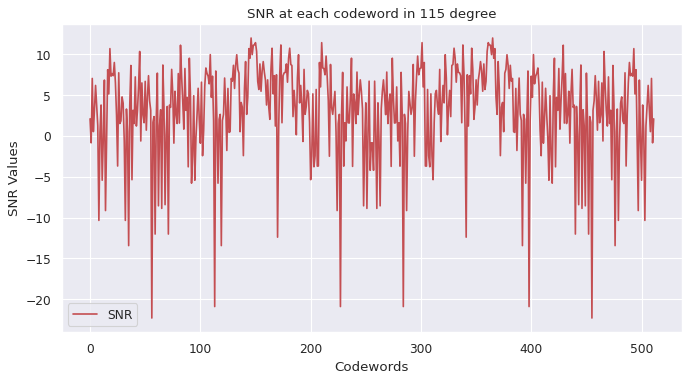

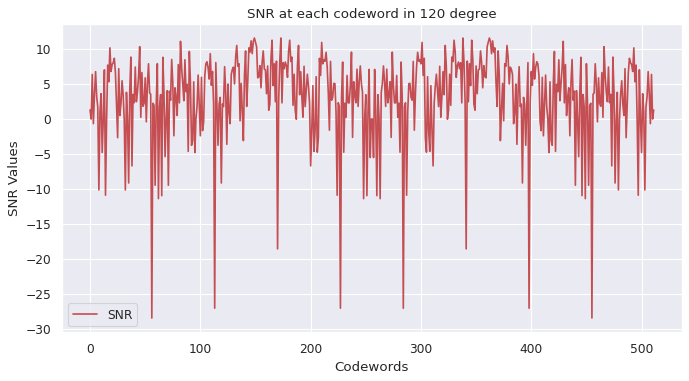

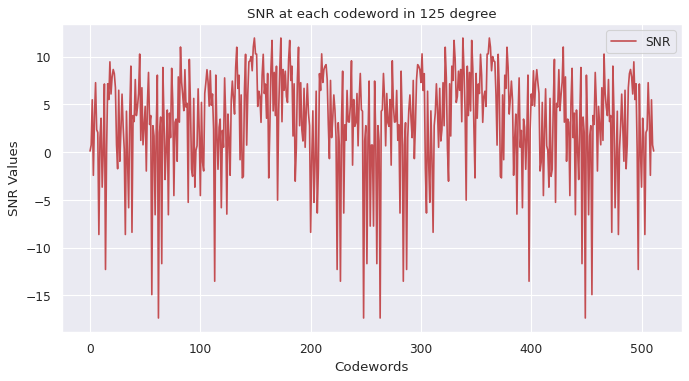

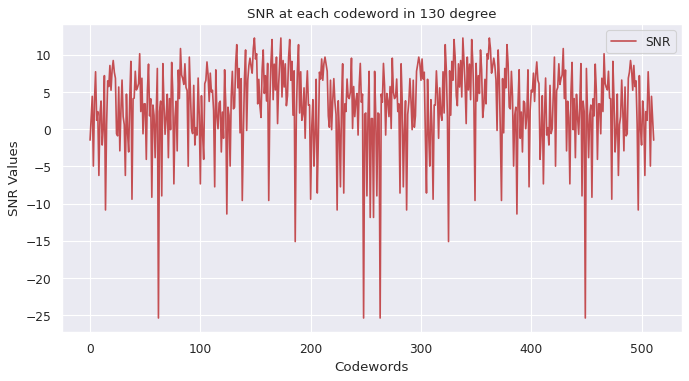

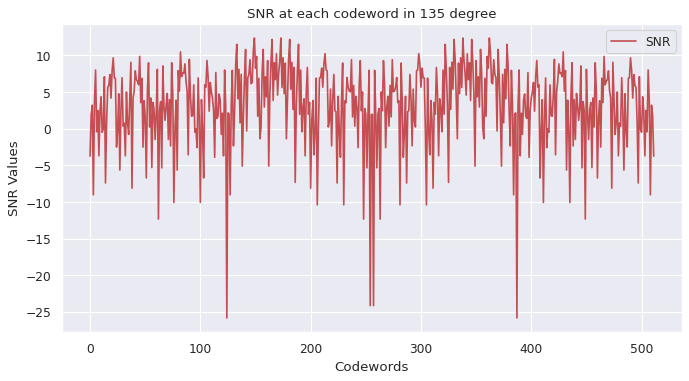

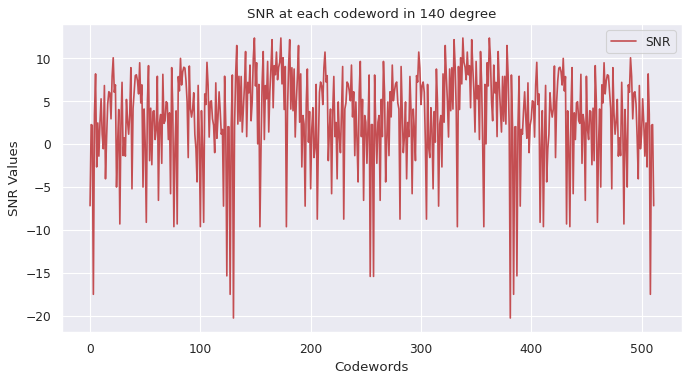

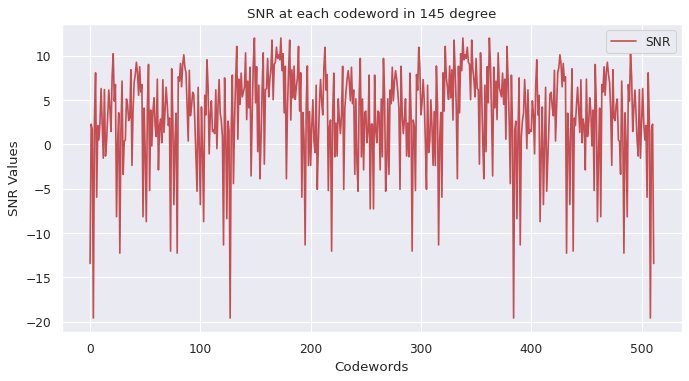

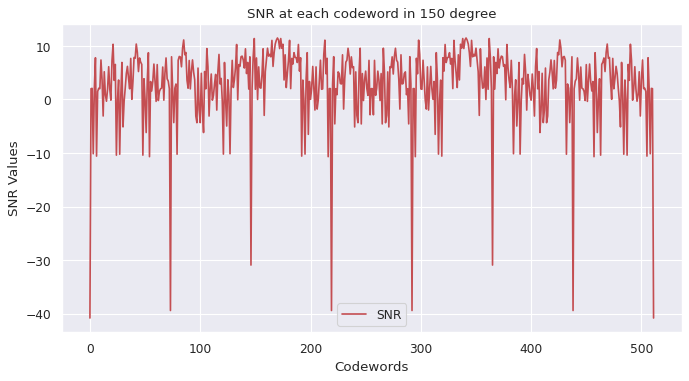

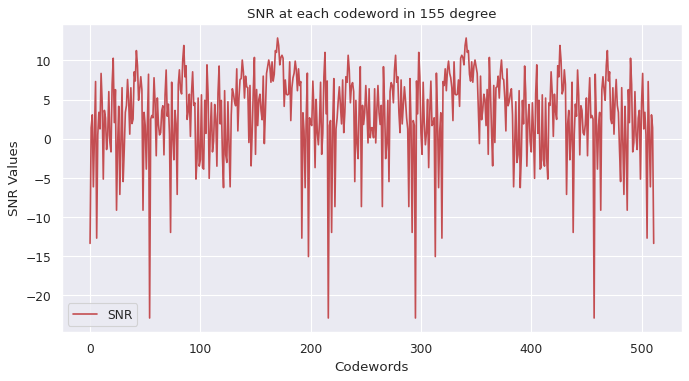

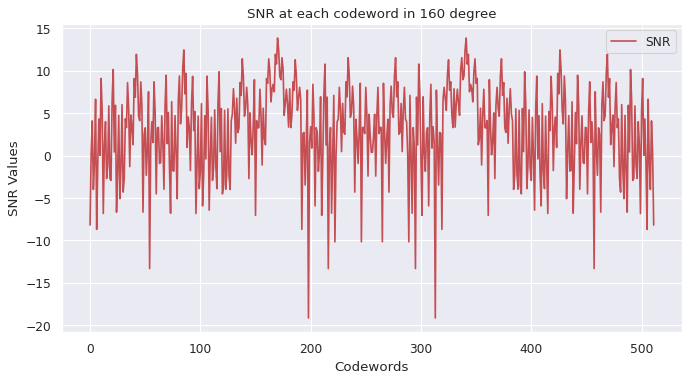

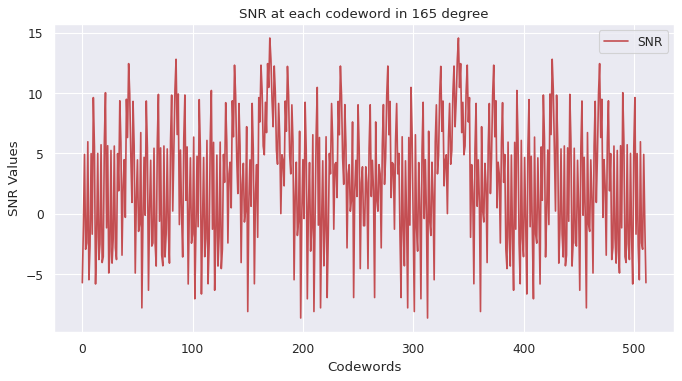

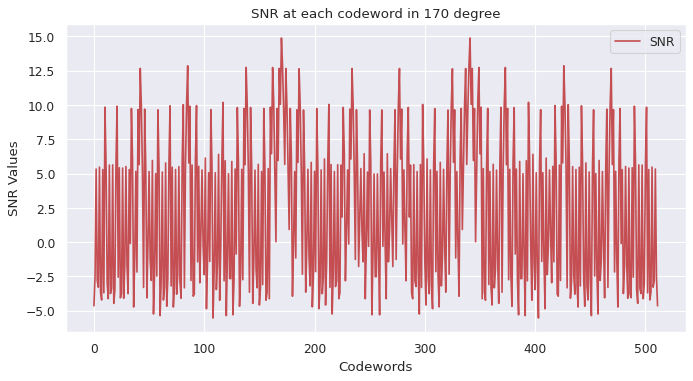

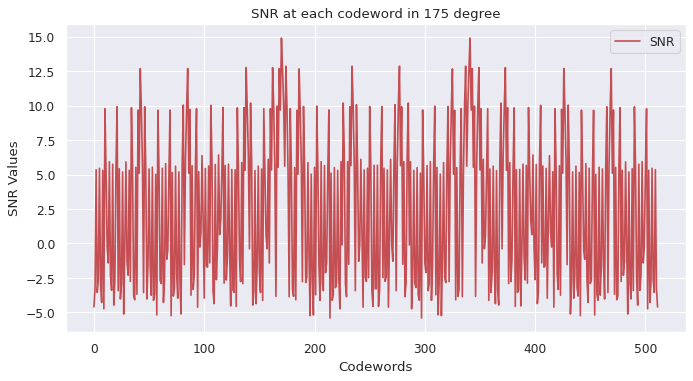

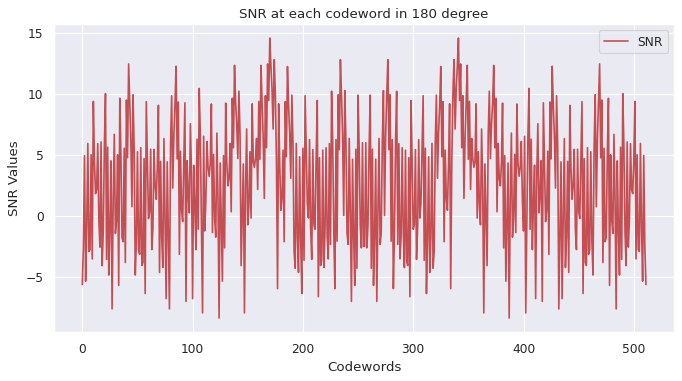

In [122]:
code_matrix = {}
# code_matrix["Angles(In Degree)"] = phi_d
phases = codewords_complex()
h_tr = Channels(theta_i, phi_i)

Tx_d1 = 5    # in Meter's
Rx_d2 = 10

for angle in phi_d:
  SNR = []
  # for index, config in enumerate(phases):
  h_ri = Channels(theta_d,angle)
  # Rx_d2 = Tx_d1*(1/m.cos(angle))*(1/m.cos(theta_d))
  dist = 1/((Tx_d1*Rx_d2)**2)
  H = tf.convert_to_tensor(np.multiply(h_tr, h_ri))
  # print(H)
  # configuration = tf.reshape(config, shape=(config.shape[0],1))
  snr_value = np.multiply(EbNo, np.multiply(dist,(abs(tf.matmul(phases, H))**2)))
  # snr_value = np.multiply(EbNo, (abs(tf.matmul(phases, H))**2))

  # snr_db = np.multiply(dist, 10*np.log10(snr_value))
  snr_db = np.round(10*np.log10(snr_value),12)
  for i in snr_db.flatten():
    SNR.append(i)
  # print(len(snr_db.flatten()))
  code_matrix[angle] = SNR
  # print(code_matrix)
  figure(figsize=(10,5), dpi=80)
  # plt.plot(SNR)
  plt.plot(SNR, linestyle='-', color='r', label='SNR')
  plt.xlabel("Codewords")
  plt.ylabel("SNR Values")
  plt.title(f"SNR at each codeword in {angle} degree")
  # plt.xticks(phi_d, phi_d)
  plt.legend()
  plt.show()

In [123]:
# # Import libraries
# from mpl_toolkits import mplot3d
# import numpy as np
# import matplotlib.pyplot as plt

# # Creating dataset
# x = np.outer(np.linspace(-3, 3, 32), np.ones(32))
# y = x.copy().T # transpose
# z = (np.sin(x **2) + np.cos(y **2) )

# # Creating figure
# fig = plt.figure(figsize =(14, 9))
# ax = plt.axes(projection ='3d')

# # Creating color map
# my_cmap = plt.get_cmap('hot')

# # Creating plot
# surf = ax.plot_surface(x, y, z,
# 					cmap = my_cmap,
# 					edgecolor ='none')

# fig.colorbar(surf, ax = ax,
# 			shrink = 0.5, aspect = 5)

# ax.set_title('Surface plot')

# # show plot
# plt.show()

# print(x.shape,y.shape,z.shape)


In [124]:
# # 3-D Surface Plot
# # Import libraries
# from mpl_toolkits import mplot3d
# import numpy as np
# import matplotlib.pyplot as plt

# Y =[]
# for i in range(512):
#   Y.append(i)
# # print(len(code_matrix.keys()))
# # print(np.reshape(list(code_matrix.values()), (len(code_matrix.keys()), len(Y))))
# # Creating dataset
# x = np.reshape(list(code_matrix.keys()), (19,1))
# y = np.reshape(Y, (512, 1))
# z = np.reshape(list(code_matrix.values()), (len(code_matrix.keys()), len(Y)))
# # print(len(list(code_matrix.values())), len(list(code_matrix.keys())), len(Y))
# # print(np.reshape(np.array(code_matrix.values()),(1, len(code_matrix.values()))).shape)
# # x = np.outer(np.linspace(-3, 3, 32), np.ones(32))
# # y = x.copy().T # transpose
# # z = (np.sin(x **2) + np.cos(y **2) )

# # Creating figure
# fig = plt.figure(figsize =(14, 9))
# ax = plt.axes(projection ='3d')

# # Creating plot
# # ax.plot(x,y,z)
# ax.plot_surface(x,y,z)

# # show plot
# plt.show()

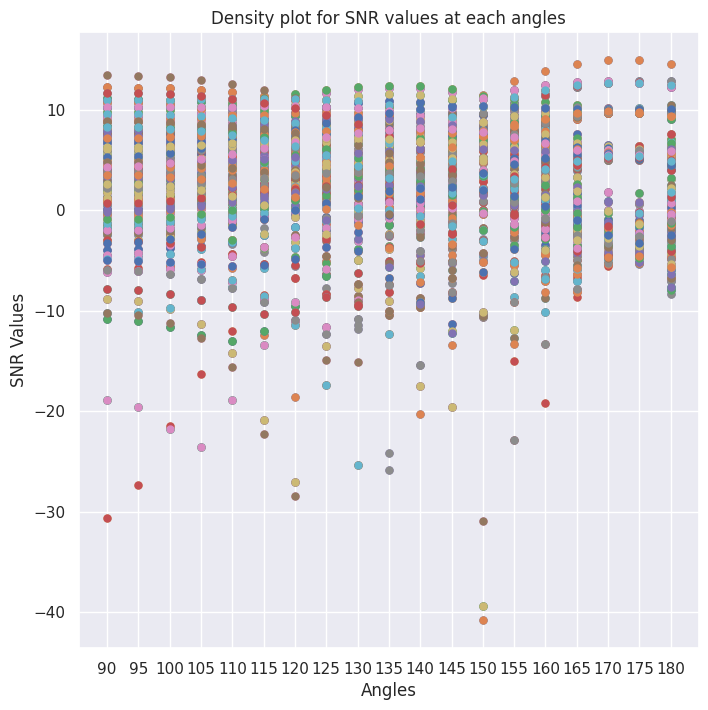

In [125]:
# Density Plot
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(8,8));
ax=fig.add_subplot(111);
ax.plot(code_matrix.keys(),code_matrix.values(),marker='.',ms=10,linestyle='none');
plt.xlabel("Angles")
plt.xticks(phi_d, phi_d)
plt.ylabel("SNR Values")
plt.title("Density plot for SNR values at each angles")
plt.show();


In [126]:
code_data = pd.DataFrame(code_matrix)
code_data

,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180
0,3.523373,3.475241,3.326058,3.061183,2.655158,2.069544,1.248434,0.108990,-1.479729,-3.750447,-7.206924,-13.445151,-40.805773,-13.356271,-8.198104,-5.729836,-4.639032,-4.603362,-5.650341
1,-3.313969,-3.201819,-2.870977,-2.341487,-1.653000,-0.864122,-0.044311,0.736278,1.413435,1.930558,2.236858,2.284082,2.023366,1.404678,0.387082,-1.008921,-2.513397,-3.282683,-2.511038
2,8.279676,8.236244,8.102173,7.866231,7.510097,7.009332,6.335996,5.465972,4.399260,3.211896,2.154315,1.679654,2.073079,3.044786,4.090794,4.897512,5.333038,5.348147,4.927541
3,2.640319,2.568899,2.348265,1.958565,1.363909,0.506612,-0.705377,-2.427870,-4.960183,-9.027284,-17.523446,-19.599005,-10.126656,-6.132825,-3.993213,-2.959431,-2.812747,-3.552374,-5.367076
4,2.158801,2.211510,2.363345,2.596082,2.881354,3.183141,3.460342,3.668839,3.762647,3.694059,3.412937,2.865858,1.997514,0.763424,-0.812734,-2.443567,-3.280512,-2.605044,-1.082830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,2.158801,2.211510,2.363345,2.596082,2.881354,3.183141,3.460342,3.668839,3.762647,3.694059,3.412937,2.865858,1.997514,0.763424,-0.812734,-2.443567,-3.280512,-2.605044,-1.082830
508,2.640319,2.568899,2.348265,1.958565,1.363909,0.506612,-0.705377,-2.427870,-4.960183,-9.027284,-17.523446,-19.599005,-10.126656,-6.132825,-3.993213,-2.959431,-2.812747,-3.552374,-5.367076
509,8.279676,8.236244,8.102173,7.866231,7.510097,7.009332,6.335996,5.465972,4.399260,3.211896,2.154315,1.679654,2.073079,3.044786,4.090794,4.897512,5.333038,5.348147,4.927541
510,-3.313969,-3.201819,-2.870977,-2.341487,-1.653000,-0.864122,-0.044311,0.736278,1.413435,1.930558,2.236858,2.284082,2.023366,1.404678,0.387082,-1.008921,-2.513397,-3.282683,-2.511038


In [127]:
code_data.to_csv("Conf_SNR.csv")

# 5. Sort this values in descending order

In [128]:
"""Sorting the SNR values in descending order and stored it in a dictionary with its index values. """
sorted_code_SNR = {}
print(type(code_data))
for angle in phi_d:
  data = {}
  ascend_data = code_data.sort_values(angle, ascending=False)
  # print(ascend_data)
  index = ascend_data.index.values.tolist()
  data["codeword"] = index
  data["SNR"] = ascend_data[angle].values
  sorted_code_SNR[angle] = data
  # [index, data[angle].values]

<class 'pandas.core.frame.DataFrame'>


# 5. Sort the SNR for greater than 10 DB

In [129]:
"""  Fix the SNR value as greater than tor equal to 10DB, and store the sorted value with its index values."""
sorted_snr_fix = {}
for angle in phi_d:
  data ={}
  ascend_data = code_data.sort_values(angle, ascending=False)
  sorted_value = ascend_data[ascend_data[angle] >=10]
  data["codeword"] = sorted_value.index.values.tolist()
  data["SNR"] = sorted_value[angle].values
  sorted_snr_fix[angle] = data

In [130]:
pd.DataFrame(sorted_snr_fix)

,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180
codeword,"[146, 365, 210, 361, 150, 301, 144, 18, 367, 4...","[146, 365, 361, 301, 210, 150, 18, 493, 144, 3...","[146, 365, 361, 150, 301, 210, 144, 18, 367, 4...","[365, 146, 361, 210, 150, 301, 493, 367, 144, ...","[146, 365, 150, 361, 301, 210, 363, 82, 148, 4...","[365, 146, 301, 210, 150, 361, 149, 173, 338, ...","[362, 338, 149, 173, 165, 181, 346, 330, 365, ...","[362, 338, 149, 173, 330, 165, 181, 346, 148, ...","[173, 338, 149, 362, 330, 346, 165, 181, 189, ...","[338, 149, 362, 173, 165, 346, 330, 181, 133, ...","[149, 173, 338, 362, 346, 330, 181, 165, 133, ...","[173, 338, 149, 362, 346, 165, 330, 181, 322, ...","[170, 341, 338, 149, 173, 362, 340, 85, 426, 1...","[170, 341, 85, 426, 340, 171, 42, 469, 343, 16...","[341, 170, 171, 85, 426, 340, 469, 42, 168, 34...","[341, 170, 340, 85, 426, 171, 42, 343, 469, 16...","[341, 170, 340, 171, 426, 85, 162, 349, 138, 3...","[341, 170, 174, 277, 337, 234, 162, 349, 138, ...","[170, 341, 337, 174, 277, 234, 343, 469, 168, ..."
SNR,"[13.411987948885, 13.411987948885, 12.21368070...","[13.363856441124, 13.363856441124, 12.18707605...","[13.214673345016, 13.214673345016, 12.10410310...","[12.949798430285, 12.949798430285, 11.95527053...","[12.543772815926, 12.543772815926, 11.72467869...","[11.958159366237, 11.958159366237, 11.38977887...","[11.546309365417, 11.546309365417, 11.54630936...","[11.938407344789, 11.938407344789, 11.93840734...","[12.232588191693, 12.232588191693, 12.23258819...","[12.377733620289, 12.377733620289, 12.37773362...","[12.321693156362, 12.321693156362, 12.32169315...","[12.009589008757, 12.009589008757, 12.00958900...","[11.481719374285, 11.481719374285, 11.38198631...","[12.854938753803, 12.854938753803, 11.90160966...","[13.869045180797, 13.869045180797, 12.46059795...","[14.544560822717, 14.544560822717, 12.78375667...","[14.889202853033, 14.889202853033, 12.86166899...","[14.90097690744, 14.90097690744, 12.8576977418...","[14.568684089279, 14.568684089279, 12.79318659..."


In [131]:
code_snr_set = {}
for angle in phi_d:
  df = {}
  unq_snr = pd.DataFrame({'SNR':sorted_snr_fix[angle]['SNR']}, index=sorted_snr_fix[angle]["codeword"])
  unq = unq_snr[unq_snr["SNR"].duplicated(keep=False)]
  df = unq.groupby(list(unq)).apply(lambda x:set(sorted(x.index))).to_dict()
  # print(f"Angle {angle} : {len(df)} set")
  code_snr_set[angle] = df
  # print(pd.DataFrame([df]).T)
codeword_set = pd.DataFrame(code_snr_set)
codeword_set.index.name = "SNR"
pd.DataFrame(codeword_set).to_csv("SNR_codeword_set.csv")
print(codeword_set)

                            90   95   100  105  110  115  120  125  130  135   
SNR                                                                            
10.137721            {297, 214}  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  \
10.219759   {360, 466, 45, 151}  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
10.677729            {130, 381}  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
10.802462  {178, 154, 357, 333}  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
10.923605   {82, 363, 148, 429}  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
12.249183                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
12.326186                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
12.440289                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
12.793187                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
14.568684                   NaN  NaN  Na

In [132]:
df_data = pd.read_csv("SNR_codeword_set.csv")
df_data.head(10)

,SNR,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180
0,10.137721,"{297, 214}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.219759,"{360, 466, 45, 151}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.677729,"{130, 381}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.802462,"{178, 154, 357, 333}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.923605,"{82, 363, 148, 429}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,11.129908,"{402, 147, 364, 109}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,11.629100,"{144, 18, 493, 367}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,12.213681,"{361, 210, 301, 150}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,13.411988,"{146, 365}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10.126966,NaN,"{297, 214}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
max_snr = {}
for i in phi_d:
  data_index = df_data[df_data[str(i)].notnull()].index
  max = 0
  for j in data_index:
    if df_data["SNR"][j] >= max :
      max = df_data["SNR"][j]
      idx = j
  max_snr[i] = df_data[str(i)][idx]
print(max_snr)

{90: '{146, 365}', 95: '{146, 365}', 100: '{146, 365}', 105: '{146, 365}', 110: '{146, 365}', 115: '{146, 365}', 120: '{338, 149, 362, 173}', 125: '{338, 149, 362, 173}', 130: '{338, 149, 362, 173}', 135: '{338, 149, 362, 173}', 140: '{338, 149, 362, 173}', 145: '{338, 149, 362, 173}', 150: '{170, 341}', 155: '{170, 341}', 160: '{170, 341}', 165: '{170, 341}', 170: '{170, 341}', 175: '{170, 341}', 180: '{170, 341}'}


In [ ]:
for index, values in max_snr.items():
  print(index, values)

In [ ]:
""" Make sets from the string loaded as csv file"""
unique_set = dict()
for index, value in max_snr.items():
  if value not in unique_set:
    data = (value.replace("{", "").replace("}", "").replace(" ","")).split(",")
    data_set = set()
    size = 0
    for x in data:
      data_set.add(int(x))
      size += 1
    unique_set[index] = data_set
    # print(size, data_set)
print(unique_set)

In [137]:
"""Check for the codeword supersets that can cover a range of angles"""
code_sets = {}
code_lst = []
idx_lst = []
cnt_set = 0

for idx, val in unique_set.items():
  cmn_angle =[]
  for k in range(cnt_set, len(unique_set.values())):

    set_data = list(unique_set.values())[k]
    if (val == set_data ):
      idx_data = list(unique_set.keys())[k]

      if (set_data not in code_lst):
        code_lst.append(set_data)
      if (idx_data not in cmn_angle):
        cmn_angle.append(idx_data)
  if (cmn_angle not in idx_lst) and len(idx_lst)== 0:
    idx_lst.append((cmn_angle))
  else :
      global superset
      superset = 0
      new_angle =[]
      for d in range(len(idx_lst)):
        for element in cmn_angle:
          if element not in idx_lst[d]:
            superset = 1
            break
          else :
            superset = 0
      if superset :
        idx_lst.append(cmn_angle)
  cnt_set += 1

print(code_lst)       # supersets or set of sets of codewords
print(idx_lst)        # Angles to be covered by this codewords


[{146, 365}, {338, 149, 362, 173}, {170, 341}]
[[90, 95, 100, 105, 110, 115], [120, 125, 130, 135, 140, 145], [150, 155, 160, 165, 170, 175, 180]]


In [138]:
# print(code_lst, idx_lst)
codeword_set =[]
global unq_code
unq_code = 0
for i in range(len(code_lst)):
  # print(code_lst[i])
  for element in code_lst[i]:
    # print(f"element")
    if (i+1) == len(code_lst):
      print(element)
      codeword_set.append(element)
    else :
      for j in range(i+1, len(code_lst)):
        if element not in code_lst[j]:
          unq_code = 1

      if unq_code == 1 :
        codeword_set.append(element)
        unq_code =0
print(codeword_set)

170
341
[146, 365, 338, 149, 362, 173, 170, 341]


In [139]:
final_codeword = []
for code in codeword_set:
  complement = (2**(RIS_ROW * RIS_COL))+(~code)
  if (complement in codeword_set) & (complement not in final_codeword):
    final_codeword.append(code)

print(final_codeword)


[146, 338, 149, 170]


In [140]:
512+(~146)

365

In [ ]:
# def checkSuperset(set1, set2):
#     isSuperset = True
#     for element in set2:
#         if element not in set1:
#             isSuperset = False
#             break
#         print(element)
#     return isSuperset


# A = {1, 2, 3, 4, 5, 6, 7, 8}
# B = {2, 4, 6, 8}
# C = {0, 1, 2, 3, 4}

# checkSuperset(A, B)

In [141]:

unique_codewords =list()
for idx, val in unique_set.items():
  for x in val :
    if (x in unique_codewords)==False:
      unique_codewords.append(x)
    break
unique_codewords

[146, 338, 170]

In [ ]:
print(np.binary_repr(146), np.binary_repr(338), np.binary_repr(170))

In [ ]:
""" Plotting all the codebooks """
sns.set()
colors = ["gray", "lightgray"]
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

for i in unique_codewords:
  # phase = np.array(i)
  phase = codewords[i]
  print(phase)
  f, ax = plt.subplots(figsize=(3,3))
  ax = sns.heatmap(phase, cmap = cmap, square = True, linewidth=0.5, cbar_kws ={"shrink": .5})
  colorbar = ax.collections[0].colorbar
  colorbar.set_ticks([0, 180])

  colorbar.set_ticklabels(['0','180'])
  plt.show()

In [ ]:
# pd.DataFrame(codeword_set[90])

In [ ]:
# SNR90 = pd.DataFrame({'SNR':sorted_snr_fix[90]['SNR']}, index=sorted_snr_fix[90]["codeword"])
# d = SNR90[SNR90["SNR"].duplicated(keep=False)]
# df = d.groupby(list(d)).apply(lambda x:set(x.index)).to_dict()
# pd.DataFrame([df]).T

In [ ]:
# SNR90 = pd.DataFrame({'SNR':sorted_snr_fix[100]['SNR']}, index=sorted_snr_fix[100]["codeword"])
# d = SNR90[SNR90["SNR"].duplicated(keep=False)]
# df = d.groupby(list(d)).apply(lambda x:set(x.index)).to_dict()
# pd.DataFrame([df]).T

In [ ]:
# import numpy as np
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# a = SNR_maximization # Store your dictionary here

# x, y = zip(*a.keys())
# z = list(a.values())

# # Plotting
# fig = plt.figure(figsize=(20,20))
# ax = fig.gca(projection = '3d')

# # dx = .25 * np.ones(len(x))
# # dy = .25 * np.ones(len(y))
# # dx = np.ones(len(x))
# # dy = np.ones(len(y))
# # dz = z

# ax.set_xlabel('Configurations')
# ax.set_ylabel('Angles')
# ax.set_zlabel('SNR')

# plt.yticks(phi_d, phi_d)
# # plt.xticks(x,x)

# ax.bar3d(x, y, z, dx, dy, dz, color = 'green')
# # ax.plot_surface(x, y, z, cmap ='viridis', edgecolor ='green')
# plt.show()